In [3]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 4.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import contractions
from sklearn.metrics import f1_score
from tqdm import tqdm
import copy

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn.utils.rnn import pack_padded_sequence

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/")

## Preprocess

In [6]:
df = pd.read_csv("train.csv", names=["rating", "title", "review"])

In [7]:
df.isna().sum()

,0
rating,0
title,207
review,0


In [17]:
def clean_df(df):
    df["title"] = df["title"].fillna("")
    df["review_length"] = df["review"].apply(len)
    df["rating"] -= 1
    return df

In [9]:
df = clean_df(df)

In [21]:
def sample(df, number_per_class):
    bins = df['review_length'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]).to_numpy()
    bins[0] = 0
    bins[-1] += 1
    bins
    labels = np.linspace(0, 4, 5)
    df['length_bin'] = pd.cut(df['review_length'], bins=bins, labels=labels)_df(df)

    # Stratified sampling: group by class and bin
    grouped = df.groupby(['rating', 'length_bin'])

    # Decide total size per class
    sample_size_per_class = number_per_class  # or whatever you want
    final_samples = []

    for label in df['rating'].unique():
        group = df[df['rating'] == label]
        bin_counts = group['length_bin'].value_counts(normalize=True)

        for bin_label, frac in bin_counts.items():
            n = int(sample_size_per_class * frac)
            subset = grouped.get_group((label, bin_label))

            if len(subset) < n:
                n = len(subset)  # safeguard
            sampled = subset.sample(n=n, random_state=42)
            final_samples.append(sampled)

    # Combine
    sampled_df = pd.concat(final_samples).sample(frac=1, random_state=42).reset_index(drop=True)
    return sampled_df

<ipython-input-20-58af84f75702>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['rating', 'length_bin'])


In [18]:
def preprocess(title, review):
    text = title + " : " + review
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'&', r'and', text)
    text = re.sub(r"[^a-z0-9!?.,:' ]+", "", text)
    text = re.sub(r'([!?.,])\1{1,}', r'\1', text)
    #separating punctuation from words for better tokenization later.
    text = re.sub(r'([!?.,])', r' \1 ', text)
    text = re.sub(r'([ ])\1{1,}', r'\1', text)
    return text

In [12]:
original_df = copy.deepcopy(df)
df = sample(original_df, 50000)
df['id'] = range(1, len(df) + 1)
df["text"] = df.apply(lambda row: preprocess(row["title"], row["review"]), axis=1)
df.drop(["title", "review", "review_length", "length_bin"], inplace=True, axis=1)

<ipython-input-10-58af84f75702>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['rating', 'length_bin'])


In [8]:
dim = 100
embed_file = f"glove.6B/glove.6B.{dim}d.txt"
embeds = {}
vocab_map = {}

#out of vocabulary vector
embeds[0] = np.zeros(dim)

#padding index vector
embeds[1] = np.zeros(dim)

with open(embed_file, "r", encoding='utf-8') as f:
    i = 2
    for l in f:
        l_split = l.split()
        word = l_split[0]
        vector = np.asarray(l_split[1:], "float32")
        vocab_map[word] = i
        embeds[i] = vector
        i += 1


In [9]:
embed_tensor = torch.stack([torch.tensor(v, dtype=torch.float32) for v in embeds.values()])

In [ ]:
# torch.save(embed_tensor, "embed_tensor.pt")

In [ ]:
# df.to_csv("preprocessed_data.csv", index=False)

## Run from preprocessed

In [ ]:
df = pd.read_csv("preprocessed_data.csv")

In [ ]:
df["id"] = list(range(1, len(df)+1))

In [5]:
embed_tensor = torch.load("embed_tensor.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'embed_tensor.pt'

99995

In [ ]:
dim = 100
embed_file = f"glove.6B/glove.6B.{dim}d.txt"
vocab_map = {}


with open(embed_file, "r", encoding='utf-8') as f:
    i = 2
    for l in f:
        l_split = l.split()
        word = l_split[0]
        vocab_map[word] = i
        i += 1


## tokenization

In [27]:
def tokenize(text):
    tokens = [vocab_map.get(word, 0) for word in text.split()]
    return torch.tensor(tokens,dtype=torch.long)



In [ ]:
df["tokens"] = df["text"].apply(tokenize)
df["length"] = df["tokens"].apply(len)

In [29]:

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    tokens, labels, lengths, ids = zip(*batch)
    lengths = torch.tensor(lengths)
    ids = torch.tensor(ids)
    padded_tokens = pad_sequence(tokens, batch_first=True, padding_value=1)
    labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)
    return padded_tokens, labels, lengths, ids

In [17]:
df_train = df.sample(frac=0.8, random_state=42)
df_val = df.drop(df_train.index)
training_dataset = list(zip(df_train["tokens"].to_list(), df_train["rating"].to_list(), df_train["length"].to_list(), df_train["id"].to_list()))
val_dataset = list(zip(df_val["tokens"].to_list(), df_val["rating"].to_list(), df_val["length"].to_list(), df_val["id"].to_list()))

training_loader = DataLoader(training_dataset, batch_size=3000, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=3000, collate_fn=collate_fn)

## LSTM model

In [10]:
class SentimentNN(nn.Module):
    def __init__(self, input_size, hidden_size, embed_tensor, lstm=True):
        super(SentimentNN, self).__init__()
        self.s_i = input_size
        self.s_h = hidden_size
        self.lstm = lstm

        self.embed_layer = nn.Embedding.from_pretrained(embed_tensor, padding_idx=1)
        self.embed_layer.weight.requires_grad = False
        if self.lstm:
            self.rnn = nn.LSTM(self.s_i, self.s_h, batch_first=True)
        else:
            self.rnn = nn.RNN(self.s_i, self.s_h, batch_first=True)
        self.dense = nn.Linear(self.s_h, 1)

    def forward(self, x, lengths):
        vec = self.embed_layer(x)
        packed_input = pack_padded_sequence(vec, lengths, batch_first=True, enforce_sorted=False)
        if self.lstm:
            output, (hn, cn) = self.rnn(packed_input)
            last_hidden = hn[-1]
        else:
            output, hn = self.rnn(packed_input)
            last_hidden = hn[-1]
        logits = self.dense(last_hidden)
        y_hat = torch.sigmoid(logits)
        return y_hat

def train(model, training_loader, lr, epochs, threshold=0.5, val_loader=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    val_f1 = np.zeros(epochs)
    for e in tqdm(range(epochs), leave=False):
        model.train()
        loss_epoch = 0
        for X_batch, y_batch, lengths, ids in training_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_hat = model(X_batch, lengths)
            loss = loss_fn(y_hat, y_batch)
            loss.backward()
            optimizer.step()

            loss_epoch += loss.item() * X_batch.shape[0]
        losses[e] = loss_epoch / len(training_loader.dataset)

        if val_loader:
            val_losses[e], val_f1[e] = validation_metrics(model, val_loader, loss_fn, threshold, device)
    return losses, val_losses, val_f1

def validation_metrics(model, val_loader, loss_fn, threshold, device):
    model.eval()

    total_loss = 0
    preds = []
    labels = []

    with torch.no_grad():
        for X_batch, y_batch, lengths, ids in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_hat = model(X_batch, lengths)
            loss = loss_fn(y_hat, y_batch)
            total_loss += loss.item() * X_batch.shape[0]
            preds.extend((y_hat > threshold).cpu().numpy().astype(int))
            labels.extend(y_batch.cpu().numpy().astype(int))

    val_f1 = f1_score(labels, preds)

    return total_loss / len(val_loader.dataset), val_f1

## Train

In [19]:
lstm_sentiment = SentimentNN(dim, 128, embed_tensor)
train_loss, val_loss, val_f1 = train(lstm_sentiment, training_loader, 0.0005, epochs=150, threshold=0.5, val_loader=val_loader)

np.float64(0.916576911779105)

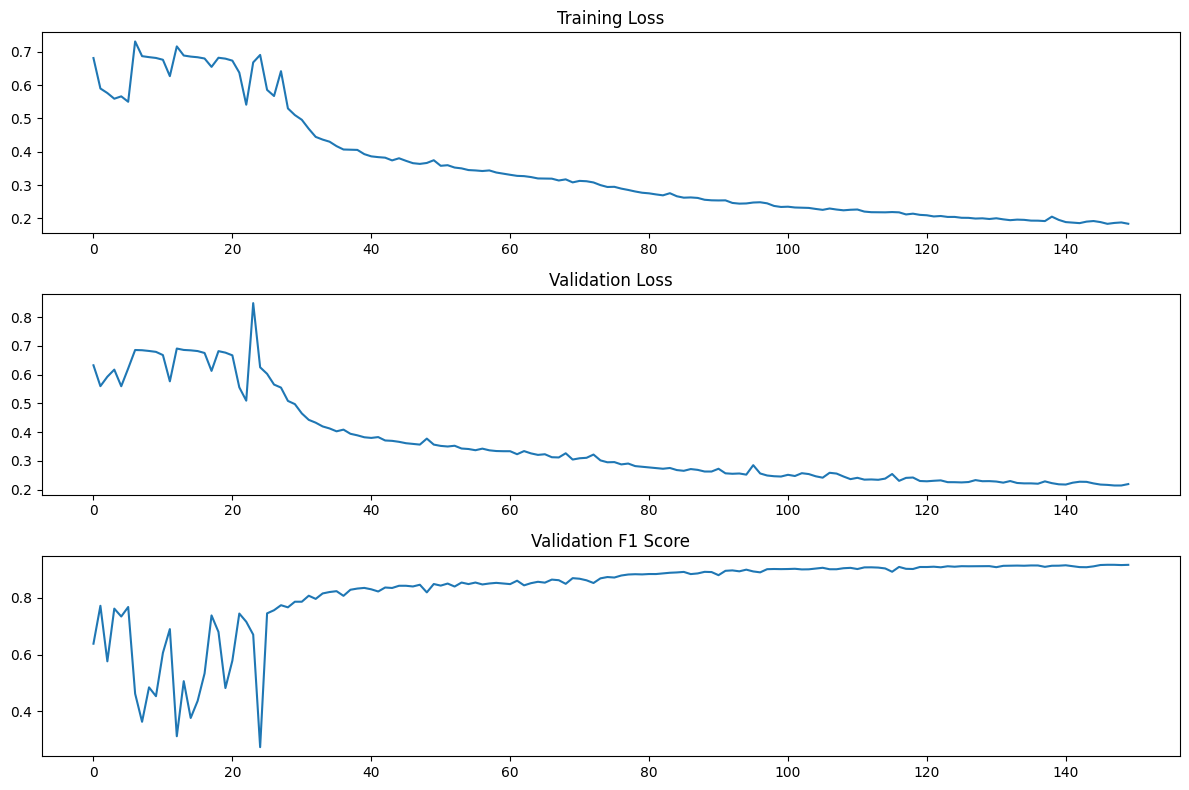

In [20]:
fig, ax = plt.subplots(3, figsize=(12, 8))
ax[0].set_title("Training Loss")
ax[0].plot(train_loss)
ax[1].set_title("Validation Loss")
ax[1].plot(val_loss)
ax[2].set_title("Validation F1 Score")
ax[2].plot(val_f1)
plt.tight_layout()
val_f1[-1]

In [21]:
lstm_sentiment.to("cpu")
model = {
    "metrics": (train_loss, val_loss, val_f1),
    "model": lstm_sentiment.state_dict()
}
torch.save(model, "lstm_sentiment.pt")
lstm_sentiment.to("cuda")

In [22]:
rnn_sentiment = SentimentNN(dim, 128, embed_tensor, lstm=False)
train_loss_rnn, val_loss_rnn, val_f1_rnn = train(rnn_sentiment, training_loader, 0.0005, epochs=200, threshold=0.5, val_loader=val_loader)

In [23]:
rnn_sentiment.to("cpu")
model = {
    "metrics": (train_loss_rnn, val_loss_rnn, val_f1_rnn),
    "model": rnn_sentiment.state_dict()
}
torch.save(model, "rnn_sentiment.pt")
rnn_sentiment.to("cuda")

np.float64(0.6254826254826255)

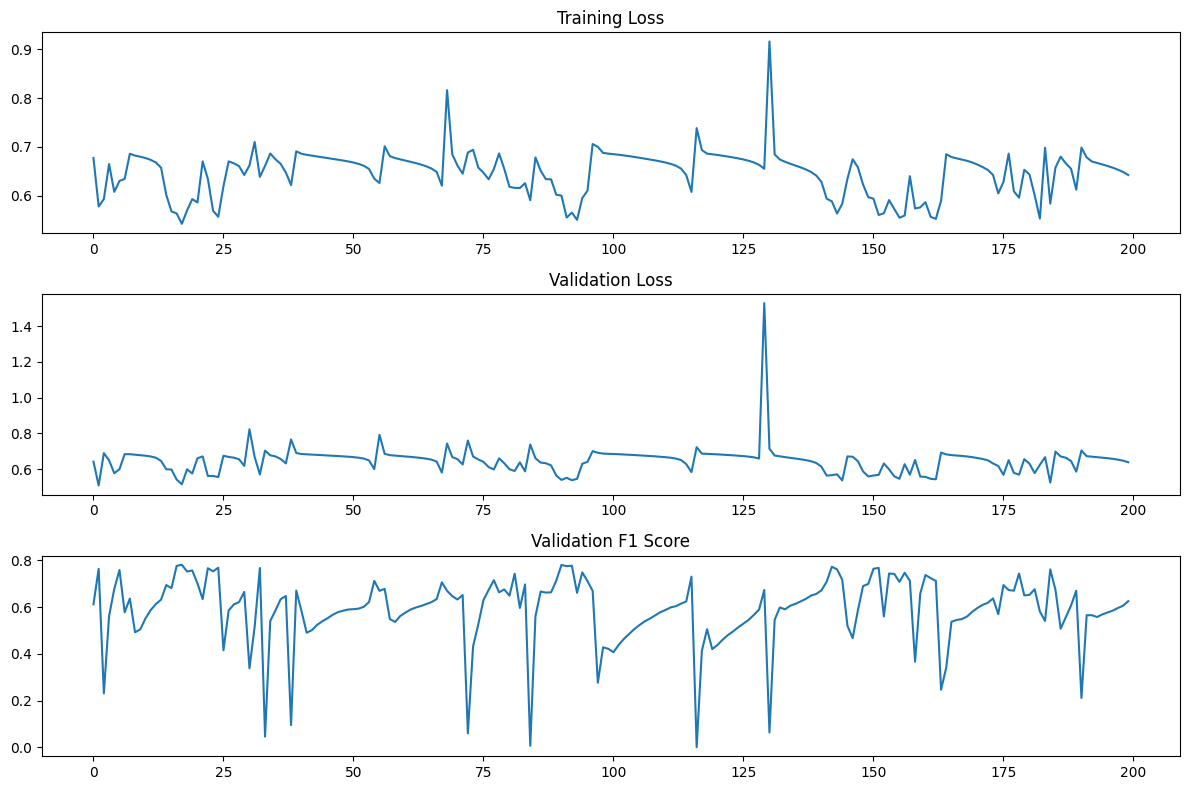

In [24]:
fig, ax = plt.subplots(3, figsize=(12, 8))
ax[0].set_title("Training Loss")
ax[0].plot(train_loss_rnn)
ax[1].set_title("Validation Loss")
ax[1].plot(val_loss_rnn)
ax[2].set_title("Validation F1 Score")
ax[2].plot(val_f1_rnn)
plt.tight_layout()
val_f1_rnn[-1]

## Test

### load model from saved state

In [11]:
dim = 100
lstm_sentiment = SentimentNN(dim, 128, embed_tensor)
model = torch.load("lstm_sentiment.pt", weights_only=False)
tloss, vloss, vf1 = model["metrics"]
lstm_sentiment.load_state_dict(model["model"])
rnn_sentiment = SentimentNN(dim, 128, embed_tensor, lstm=False)
model = torch.load("rnn_sentiment.pt", weights_only=False)
tloss_r, vloss_r, vf1_r = model["metrics"]
rnn_sentiment.load_state_dict(model["model"])

<All keys matched successfully>

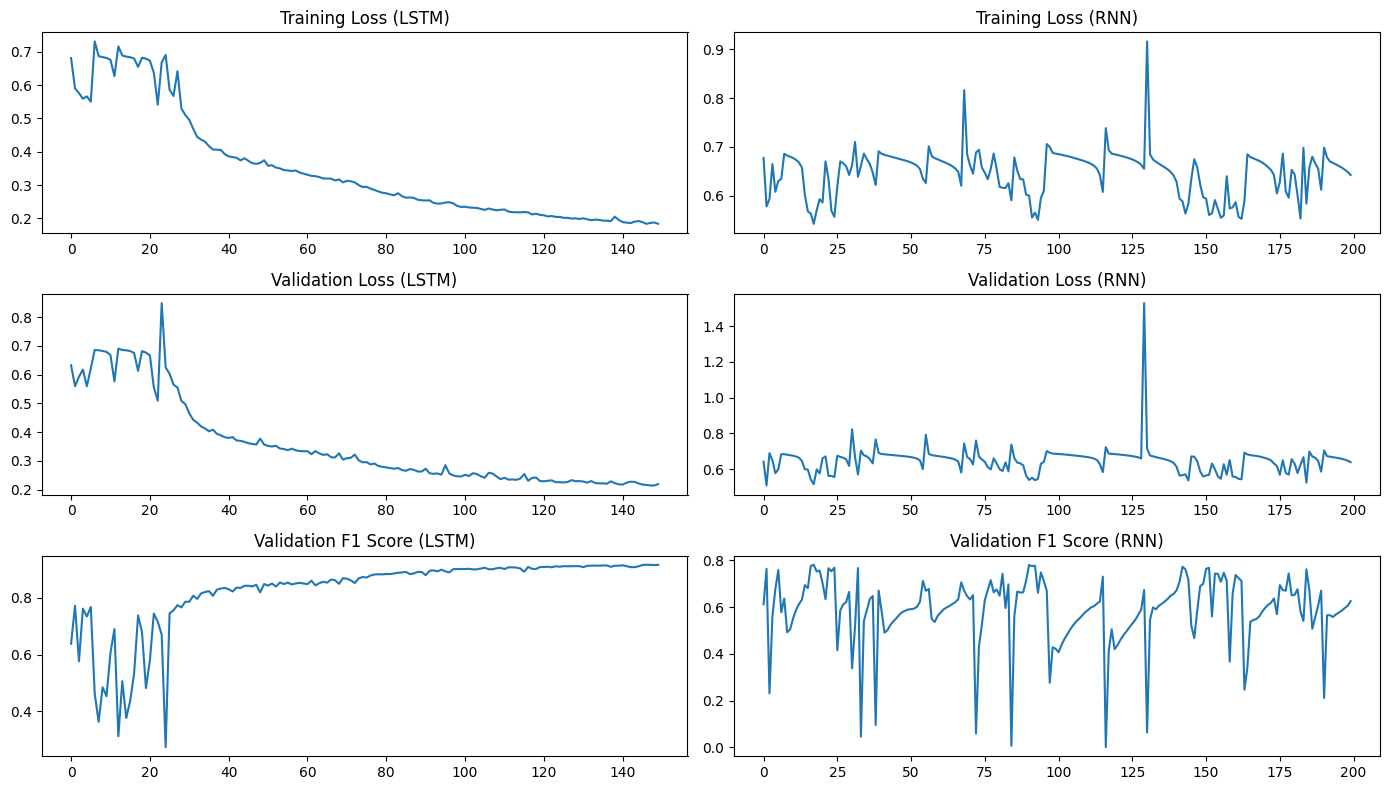

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(14, 8))
ax[0][0].set_title("Training Loss (LSTM)")
ax[0][0].plot(tloss)
ax[1][0].set_title("Validation Loss (LSTM)")
ax[1][0].plot(vloss)
ax[2][0].set_title("Validation F1 Score (LSTM)")
ax[2][0].plot(vf1)
ax[0][1].set_title("Training Loss (RNN)")
ax[0][1].plot(tloss_r)
ax[1][1].set_title("Validation Loss (RNN)")
ax[1][1].plot(vloss_r)
ax[2][1].set_title("Validation F1 Score (RNN)")
ax[2][1].plot(vf1_r)
plt.tight_layout()

### df_test

In [24]:
df_test = clean_df(pd.read_csv("test.csv", names=["rating", "title", "review"]))

In [25]:
df_test = sample(df_test, 200000)
df_test["text"] = df_test.apply(lambda row: preprocess(row["title"], row["review"]), axis=1)
df_test.drop(["title", "review", "review_length", "length_bin"], inplace=True, axis=1)

<ipython-input-21-58af84f75702>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['rating', 'length_bin'])


In [ ]:
df_test["tokens"] = df_test["text"].apply(pad_and_tokenize)
df_test["length"] = df_test["tokens"].apply(len)
df_test["id"] = list(range(1, len(df_test)+1))
test_dataset = list(zip(df_test["tokens"].to_list(), df_test["rating"].to_list(), df_test["length"].to_list(), df_test["id"].to_list()))

In [30]:
test_loader = DataLoader(test_dataset, batch_size=3000, collate_fn=collate_fn)

In [31]:
def test_model(model, test_loader, threshold, device):
    model.eval()

    probs = []
    preds = []
    labels = []
    all_ids = []

    with torch.no_grad():
        for X_batch, y_batch, lengths, ids in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_hat = model(X_batch, lengths)

            probs.extend(y_hat.cpu().numpy().flatten().astype(float))
            preds.extend((y_hat > threshold).cpu().numpy().flatten().astype(int))
            labels.extend(y_batch.cpu().numpy().flatten().astype(int))
            all_ids.extend(ids.cpu().numpy().flatten().astype(int))

    df_results = pd.DataFrame({
        'id': all_ids,
        'label': labels,
        'pred': preds,
        'prob': probs
    })

    return df_results

In [32]:
df_results = test_model(lstm_sentiment, test_loader, 0.5, "cpu")
df_results = pd.merge(df_results, df_test[['id', 'text']], on='id', how='left')

In [33]:
labels = df_results["label"].to_numpy()
preds = df_results["pred"].to_numpy()


Accuracy: 91.132
F1_score: 0.9122149683971906
Confusion Matrix:


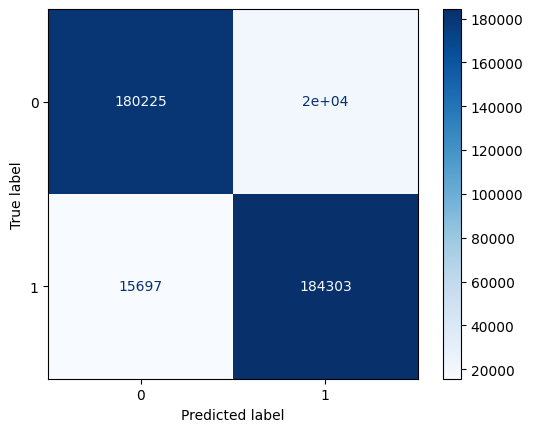

In [36]:
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
print(f"""
Accuracy: {np.sum(labels == preds) / len(df_results) * 100}
F1_score: {f1_score(labels, preds)}
Confusion Matrix:""")
ConfusionMatrixDisplay.from_predictions(labels, preds, cmap="Blues")
plt.show()

## Analysis

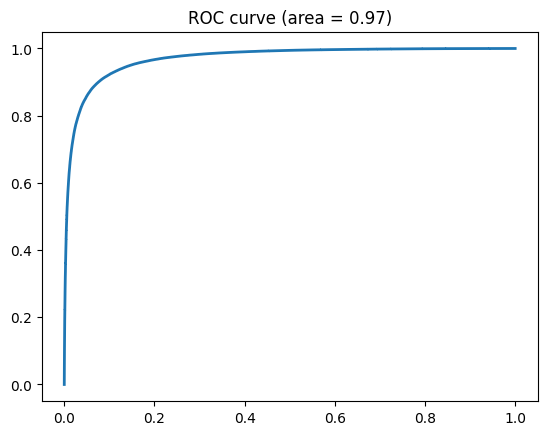

In [35]:
probs = df_results["prob"].to_numpy()
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2)
plt.title('ROC curve (area = %0.2f)' % roc_auc)
plt.show()

In [40]:
df_results.to_csv("wrong_predictions.csv")

In [58]:
torch.cuda.empty_cache()

In [ ]:
val_f1[-1]

np.float64(0.8998073217726397)

In [41]:
df_results

,id,label,pred,prob,text
0,1,1,1,0.989816,great rice : i love this rice it never comes o...
1,2,1,1,0.548107,weather forecast : i live abroad from usa . th...
2,3,1,1,0.967588,an absolute mustread ! : i cannot say enough g...
3,4,1,1,0.990064,review of brave wolf and the thunderbird: tale...
4,5,0,1,0.809537,fk naw . do not quit you are day job . : that ...
...,...,...,...,...,...
399995,399996,0,0,0.409260,beware ! : i will admit this is a wonderfully ...
399996,399997,0,0,0.002034,poorly done : i was willing to overlook many s...
399997,399998,1,1,0.997015,the day the earth stood still 1951 : this is t...
399998,399999,1,1,0.997255,find the beauty in every moment : the thief co...


In [ ]:
len(df)

109995